# Movie recommendation system
This notebook was written as a part of an evaluation assignment for Styria from September 30th to October 16th 2017 in Zagreb, Croatia by Ivan Pandžić. The evaluation assignment consists of four parts:
1. Exploring the MovieLens 20M Dataset and specifying interesting findings about it.
2. Developing a software solution, using Python 3, which will be able to suggest to users which movies to watch based on their ratings of previously watched movies. 
3. Evaluating the software solution described in (2.).
4. Presenting the software solution in a suitable form (for instance, an ipynb).

In solving these tasks, I used numpy, pandas, matplotlib, seaborn and scikit-learn.

I also used the official scikit-learn documentation, several books, such as "Hands-on Machine Learning with Scikit-Learn and TensorFlow" (http://shop.oreilly.com/product/0636920052289.do) and "Mastering Machine Learning with Python in six Steps" (http://www.apress.com/us/book/9781484228654), as well as various blogs, for instance:
1. https://datatoanalytics.wordpress.com/2016/12/07/recommender-system-a-comparative-study/
2. http://pythonforengineers.com/data-analysis-with-pandas/
3. https://medium.com/towards-data-science/learning-to-rank-with-python-scikit-learn-327a5cfd81f
4. http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/

In [1]:
import re
from collections import Counter
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split

## 1. Exploring the MovieLens 20M Dataset


The MovieLens 20M Dataset describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 20000263 ratings and 465564 tag applications across 27278 movies.

In order to explore the MovieLens 20M Dataset, we first load the six csv files from the ml-20m folder (`genome-scores.csv`, `genome-tags.csv`, `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`) and convert them into dataframes using pandas.

In [2]:
movies = pd.read_csv('ml-20m/movies.csv')
print(movies.shape)
movies.head()

(27278, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


The **movies** dataframe has 27278 rows and three columns labeled **movieId**, **title** and **genres**. In order to make the dataframe more usable, we add separate columns for each genre and delete the **genres** column which we do not need anymore. We also delete the newly created **(no genres listed)** column, which doesn't seem useful.

In [3]:
movies = pd.concat([movies, movies.genres.str.get_dummies(sep='|')], axis=1)
del movies["genres"]
del movies["(no genres listed)"]
print(movies.shape)
movies.head()

(27278, 21)


,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The **movies** dataframe now has 21 columns instead of three: **movieId**, **title**, **Action**, **Adventure**, **Animation**, **Children**, **Comedy**, **Crime**, **Documentary**, **Drama**, **Fantasy**, **Film-Noir**, **Horror**, **IMAX**, **Musical**, **Mystery**, **Romance**, **Sci-Fi**, **Thriller**, **War** and **Western**.

We create a year list (**year_list**) in order to plot a year distribution bar chart.

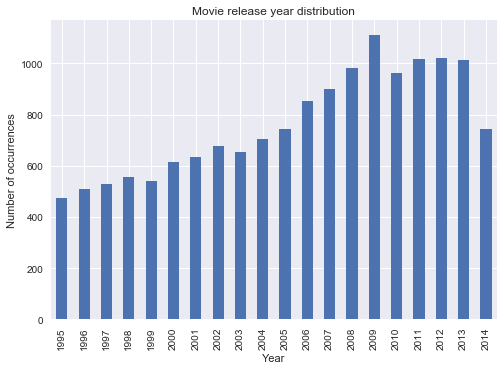

In [4]:
year_list = []
for row in movies["title"]:
    x = re.search(r"\(\d{4}\)", row)
    if x:
        y = x.group(0)
    year_list.append(y[1:-1])

year_count = Counter(year_list)
year_count_30 = year_count .most_common(20)
year_dict = dict(year_count_30)
year_df = pd.DataFrame(year_dict, index=[0])

plt.title("Movie release year distribution")
plt.xlabel("Year")
plt.ylabel("Number of occurrences")
year_df.iloc[-1].plot(kind='bar')

The data in MovieLens 20M was created between January 09, 1995 and March 31, 2015, so it is reasonable that movies released in 2015 are not represented in the top 20 of the Year distribution bar graph and that movies released prior to 1995 are not in the top 20 of the Year distribution bar graph.

In [5]:
movies.loc["Total"] = movies.sum(numeric_only=True)
movies.iloc[-1, movies.columns.get_loc('movieId')] = "None"
movies.tail()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
27274,131256,"Feuer, Eis & Dosenbier (2002)",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27275,131258,The Pirates (2014),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27276,131260,Rentun Ruusu (2001),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27277,131262,Innocence (2014),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Total,None,NaN,3520.0,2329.0,1027.0,1139.0,8374.0,2939.0,2471.0,13344.0,...,330.0,2611.0,196.0,1036.0,1514.0,4127.0,1743.0,4178.0,1194.0,676.0


We calculate a total of different genres for the entire **movies** dataframe in order to create a Genre distribution bar chart.

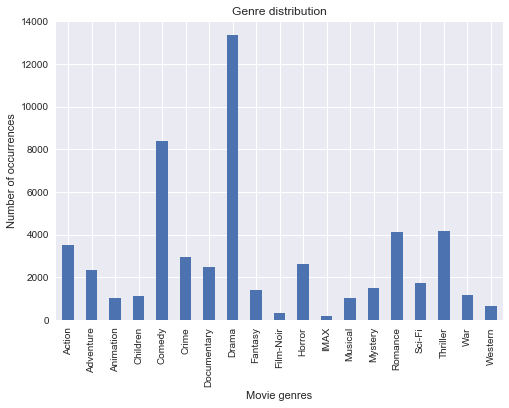

In [6]:
total_row = movies.iloc[-1]
total_row = total_row.drop(['movieId', 'title'])
plt.xlabel("Movie genres")
plt.ylabel("Number of occurrences")
plt.title("Genre distribution")
total_row.plot(kind='bar')

As we can see from the bar chart, **Drama**, **Comedy**, **Thriller**, **Romance** and **Action** are the five most frequent genres in the MovieLens 20M dataset.

In [7]:
ratings = pd.read_csv('ml-20m/ratings.csv')
print(ratings.shape)
ratings.head()

(20000263, 4)


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [8]:
ratings_mean = ratings["rating"].mean()
print(ratings_mean)

3.5255285642993797


The **ratings** dataframe has 20000263 rows and four columns labeled **userId**, **movieId**, **rating** and **timestamp**. The ratings mean is 3.526.

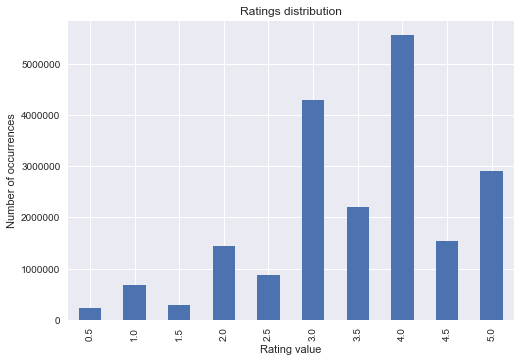

In [9]:
ratings_list = ratings["rating"].tolist()
ratings_count = Counter(ratings_list)
ratings_dict = dict(ratings_count)

ratings_count_df = pd.DataFrame(ratings_dict, index=[0])

plt.title("Ratings distribution")
plt.xlabel("Rating value")
plt.ylabel("Number of occurrences")
ratings_count_df.iloc[-1].plot(kind='bar')

It is interesting to note from the graph that whole number ratings (1.0, 2.0, 3.0, 4.0 and 5.0) are more frequent than .5 ratings (0.5, 1.5, 2.5, 3.5 and 4.5).

By merging the **movies** and **ratings** dataframe into the **movie_data** dataframe, we can determine the top rated movies in MovieLens 20M.

In [10]:
movie_data = pd.merge(movies, ratings)

In [11]:
print("Top rated movies in MovieLens 20M:\n"), movie_data.groupby('title').size().sort_values(ascending=False)[:20]

Top rated movies in MovieLens 20M:



(None, title
 Pulp Fiction (1994)                                      67310
 Forrest Gump (1994)                                      66172
 Shawshank Redemption, The (1994)                         63366
 Silence of the Lambs, The (1991)                         63299
 Jurassic Park (1993)                                     59715
 Star Wars: Episode IV - A New Hope (1977)                54502
 Braveheart (1995)                                        53769
 Terminator 2: Judgment Day (1991)                        52244
 Matrix, The (1999)                                       51334
 Schindler's List (1993)                                  50054
 Toy Story (1995)                                         49695
 Fugitive, The (1993)                                     49581
 Apollo 13 (1995)                                         47777
 Independence Day (a.k.a. ID4) (1996)                     47048
 Usual Suspects, The (1995)                               47006
 Star Wars: Episode VI - Re

Let's look at the top 20 movies from IMDB (http://www.imdb.com/chart/top).
    
     1. The Shawshank Redemption (1994)	9.2		
 	2. The Godfather (1972)	9.2		
 	3. The Godfather: Part II (1974)	9.0		
 	4. The Dark Knight (2008)	9.0		
 	5. 12 Angry Men (1957)	8.9		
 	6. Schindler's List (1993)	8.9		
 	7. Pulp Fiction (1994)	8.9		
 	8. The Lord of the Rings: The Return of the King (2003)	8.9		
 	9. The Good, the Bad and the Ugly (1966)	8.8		
 	10. Fight Club (1999)	8.8		
 	11. The Lord of the Rings: The Fellowship of the Ring (2001)	8.8		
 	12. Forrest Gump (1994)	8.7		
 	13. Star Wars: Episode V - The Empire Strikes Back (1980)	8.7		
 	14. Inception (2010)	8.7		
 	15. The Lord of the Rings: The Two Towers (2002)	8.7		
 	16. One Flew Over the Cuckoo's Nest (1975)	8.7		
 	17. Goodfellas (1990)	8.7		
 	18. The Matrix (1999)	8.7		
 	19. Seven Samurai (1954)	8.6		
 	20. Star Wars: Episode IV - A New Hope (1977)	8.6
    
Some of the movies that are in the IMDB top 20, like The Shawshank Redemption, Star Wars: Episode IV and Star Wars: Episode V are also in the MovieLens 20M top 20, but the IMDB top 20 contains more movies released before 1985, like The Godfather, 12 Angry Men, The Good, the Bad and the Ugly, and less movies released after 1985.

In [12]:
tags = pd.read_csv('ml-20m/tags.csv')
print(ratings.shape)
tags.head()

(20000263, 4)


,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


The **tags** dataframe has 20000263 rows and four columns labeled **userId**, **movieId**, **tag** and **timestamp**.
We use the Counter module to calculate the 10 most frequent tags and create a bar plot

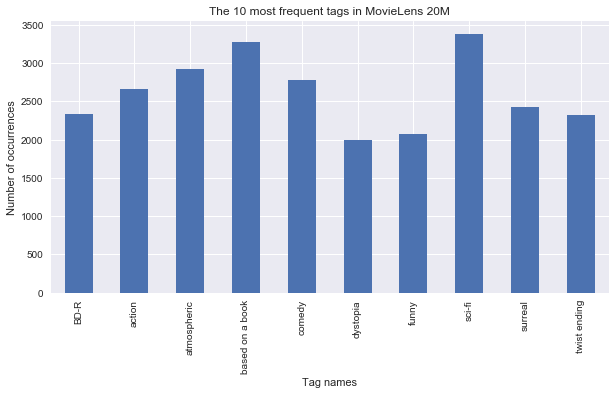

In [13]:
tags_list = tags["tag"].tolist()
tag_count = Counter(tags_list)
tag_count_10 = tag_count.most_common(10)
tag_10_dict = dict(tag_count_10)
plt.rcParams["figure.figsize"] = [10,5]

df = pd.DataFrame(tag_10_dict, index=[0])
df_row = df.iloc[-1]

plt.title("The 10 most frequent tags in MovieLens 20M")
plt.xlabel("Tag names")
plt.ylabel("Number of occurrences")
df_row.plot(kind='bar')

In [14]:
links = pd.read_csv('ml-20m/links.csv')
print(links.shape)
links.head()

(27278, 3)


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


The **links** dataframe has 27278 rows and three columns labeled **movieId**, **imdbId** and **tmdbId**.

In [15]:
genome_tags = pd.read_csv('ml-20m/genome-tags.csv')
print(genome_tags.shape)
genome_tags.head()

(1128, 2)


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


The **genome_tags** dataframe has 20000263 rows and two columns labeled tagId, imdbId and tag.

In [16]:
genome_scores = pd.read_csv('ml-20m/genome-scores.csv', engine='python')
print(genome_scores.shape)
genome_scores.head()

(11709768, 3)


,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


The **genome_score** dataframe has 11709768 rows and three columns labeled **movieId**, **tagId** and **relevance**.

## 2. Developing a Movie Recommendation System

The two most common approaches to developing a movie recommendation system are content based filtering, which uses information about the product, and collaborative filtering, which uses user generated data. 
Based on a comparative study by A. K. Sujatha of four different models for building a movie recommendation system (https://datatoanalytics.wordpress.com/2016/12/07/recommender-system-a-comparative-study/), we chose to use the collaborative filtering approach together with the Stochastic gradient descent algorithm in order to develop a movie recommendation system.

Out of the six csv files we loaded as dataframes, we will only use two, **movies** and **ratings**. In order to avoid a MemoryError, we slice the **ratings** dataframe, using only the first 100 000 rows. Depending on the hardware used to run this notebook, this number can be increased or decreased. Since the **ratings** dataframe is sorted according to the userId, we chose to use the first 100 000 rows instead of, for example, keeping every two-hundreth row. Our assumption was that it is more informative to have more ratings on a smaller number of users than smaller numbers of ratings per user on a larger subset of users.

In [17]:
ratings = ratings.iloc[:100000,:]
print(ratings.shape)

(100000, 4)


Since we reduced the number of rows in the **ratings** dataframe, we also reduce the number of rows in the  **movies** dataframe, keeping only those rated in the 100000 version row of the **ratings** dataframe. 

In [18]:
rated_movies_list = list(set(ratings.movieId.tolist()))
rated_movies_df = movies[movies['movieId'].isin(rated_movies_list)]

We sort the **ratings** dataframe according to **movieId** instead of **userId**.

In [19]:
ratings_resorted = ratings.sort_values("movieId")
ratings_resorted.tail()

,userId,movieId,rating,timestamp
89704,631,119141,3.0,1426930836
98732,692,125916,0.5,1424303273
3779,31,125916,0.5,1424733607
36851,284,128488,3.0,1424885756
98733,692,128594,0.5,1424303283


In order to avoid a future IndexError, we replace the movieId column of the **ratings_resorted** dataframe with a list of sequential numbers starting with zero.

In [20]:
movieId_list_unique = sorted(list(set(ratings_resorted["movieId"].tolist())), key=int)
num_of_ratings = list(range(0, ratings_resorted.shape[0]))
movieId_dict = dict(zip(movieId_list_unique, num_of_ratings))
movieId_list = ratings_resorted["movieId"].tolist()
new_movieId_list = []
counter = 0
placeholder = 1

for item in movieId_list:
    if item == placeholder:
        new_movieId_list.append(counter)
    else:
        counter += 1
        new_movieId_list.append(counter)
        placeholder = item
        
ratings_resorted["movieId"] = new_movieId_list
ratings_resorted.tail()

,userId,movieId,rating,timestamp
89704,631,8223,3.0,1426930836
98732,692,8224,0.5,1424303273
3779,31,8224,0.5,1424733607
36851,284,8225,3.0,1424885756
98733,692,8226,0.5,1424303283


We remap the movieId in the **rated_movies_df** dataframe. 

In [21]:
rated_movies_df["movieId"] = rated_movies_df.movieId.map(movieId_dict)
rated_movies_df.tail()

,movieId,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
25222,8222,Into the Woods (2014),0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25253,8223,The Interview (2014),1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26159,8224,Fifty Shades of Grey (2015),0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26701,8225,Wild Card (2015),0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26741,8226,Boy Meets Girl (2015),0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


We resort the **ratings** dataframe by userId, returning it to its original state.

In [22]:
ratings = ratings_resorted.sort_values("userId")

We define several functions which will be used later on.

In [23]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))
 
def top_k_movies_byuser(prediction, mapper, user_idx, k=6):
    return [mapper[x] for x in np.argsort(prediction[user_idx,np.where(train_data_matrix[user_idx, :] == 0)[0]])[:-k-1:-1]]

def predict(P,Q):
    return np.dot(P.T,Q)

We split the data into train and test data using scikit-learn. We create two user-item matrices, **train_data_matrix** and **test_data_matrix**. 

In [24]:
trainRMSE = []
testRMSE = []

n_users = ratings.userId.unique().shape[0]
n_items = ratings.movieId.unique().shape[0]

train_data, test_data = train_test_split(ratings, test_size=0.25)

train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]
    
test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

We define parameters such as **iterations** and **gamma**, as well as **user_idx**, i.e. the user from the **ratings** dataframe, who will receive recommendations based on movies he or she has previously rated. 

In [25]:
idx_to_movie = {}
for index, row in rated_movies_df.iterrows():
    idx_to_movie[int(row["movieId"])] = row["title"]
    
user_idx = 9

lmbda = 0.1
k = 20
m, n = train_data_matrix.shape
iterations = 100
gamma = 0.01

rated_by_user = ratings.loc[ratings['userId'] == user_idx+1]
rated_by_user_idlist = rated_by_user["movieId"].tolist()
rated_by_user_names = movies[movies['movieId'].isin(rated_by_user_idlist)]
rated_by_user_names = rated_by_user_names["title"].tolist()

We generate several movie recommendations for the user with a **user_idx** value of 9.

In [26]:
user_feature = 3 * np.random.rand(k,m)
movie_feature = 3 * np.random.rand(k,n)
train_errors = []
test_errors = []
 
users,items = train_data_matrix.nonzero()
for iter in range(iterations):
    for u, i in zip(users,items):
        e = train_data_matrix[u, i] - predict(user_feature[:,u],movie_feature[:,i])
        user_feature[:,u] += gamma * (e * movie_feature[:,i] - lmbda * user_feature[:,u])
        movie_feature[:,i] += gamma * (e * user_feature[:,u] - lmbda * movie_feature[:,i])
        
    pred = predict(user_feature, movie_feature)
    train_rmse = rmse(pred, train_data_matrix)
    test_rmse = rmse(pred, test_data_matrix)
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)
    
pred = predict(user_feature, movie_feature)
sgdBasedTrainRMSE = rmse(pred, train_data_matrix)
sgdBasedTestRMSE = rmse(pred, test_data_matrix)
trainRMSE.append(sgdBasedTrainRMSE)
testRMSE.append(sgdBasedTestRMSE)
 
print("Movies recommended to user " + str(user_idx) + " are:")
nearestMovies = top_k_movies_byuser(pred, idx_to_movie, user_idx)
for item in nearestMovies:
    if item not in rated_by_user_names:
        print(item)

Movies recommended to user 9 are:
Secret Life of Walter Mitty, The (2013)
Battle Royale (Batoru rowaiaru) (2000)
Night Moves (1975)
Battle Creek Brawl (Big Brawl, The) (1980)
Roustabout (1964)
Late Marriage (Hatuna Meuheret) (2001)


## 3. Evaluating the Movie Recommendation System

In order to evaluate the Recommendation System, we print the already calculated  root-mean-squared-error using both the train data and the test data.

In [27]:
print('User-based CF MSE on train data: ' + str(sgdBasedTrainRMSE))
print('User-based CF MSE on test data: ' + str(sgdBasedTestRMSE) + "\n")

User-based CF MSE on train data: 0.6682603979038517
User-based CF MSE on test data: 1.1219003828996037



The results are better than the root-mean-squared-errors calculated in "Mastering Machine Learning with Python in six Steps":

User-based CF RMSE: 1.0705767849

Item-based CF RMSE: 1.37392288971

The results are also better than the root-mean-squared-errors calculated in the comparative study on movie recommender systems by A. K. Sujatha when algorithms other than SGD are used and similar when SGD is used (https://datatoanalytics.wordpress.com/2016/12/07/recommender-system-a-comparative-study/).

We plot the **train_errors** list in order to see whether the number of epochs, i.e. the **iterators** variable, which was set to 100, was sufficiently large.

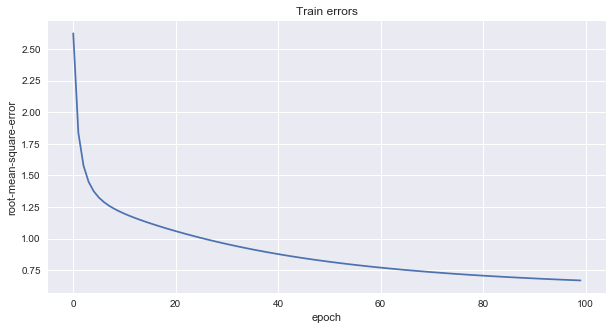

In [28]:
plt.plot(train_errors)
plt.title("Train errors")
plt.xlabel('epoch')
plt.ylabel('root-mean-square-error')
plt.show()

The graph indicates that 100 epochs were beneficial to reducing the root-mean-square-error and that a larger **iterations** variable would not significantly reduce the root-mean-square-error. We also plot the **test_errors list**, which also indicated that a larger iterations variable is not necessary.

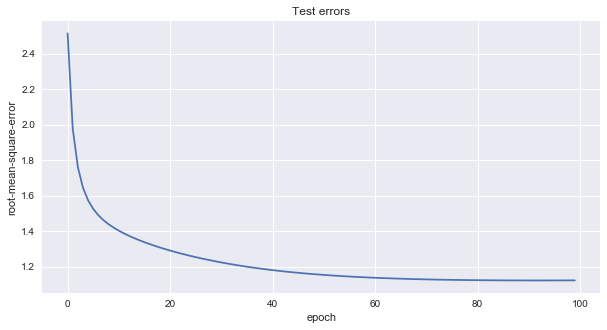

In [29]:
plt.plot(test_errors)
plt.title("Test errors")
plt.xlabel('epoch')
plt.ylabel('root-mean-square-error')
plt.show()

We also compare the ratings the user made with predicted ratings.

In [30]:
ratings_compare = pd.DataFrame(columns = ("Actual Rating","Predicted Rating"))
ratings_compare["Actual Rating"] = train_data_matrix[user_idx,np.where(train_data_matrix[user_idx, :] > 0)[0]][0:10]
ratings_compare["Predicted Rating"] = pred[user_idx,np.where(train_data_matrix[user_idx, :] > 0)[0]][0:10]
print(ratings_compare)

   Actual Rating  Predicted Rating
0            4.0          3.358874
1            4.0          3.420039
2            4.0          4.136990
3            3.0          3.779061
4            5.0          4.176160
5            5.0          4.299403
6            4.0          4.012787
7            4.0          3.873009
8            3.0          3.375232
9            4.0          3.868373


## 4. Additional Test cases

We will consider the already executed code to be first test case (with gamma = 0.01). In the second test case, we will use a gamma roughly three times smaller (gamma = 0.0033). 

In [31]:
gamma = 0.0033

In [32]:
user_feature = 3 * np.random.rand(k,m)
movie_feature = 3 * np.random.rand(k,n)
train_errors = []
test_errors = []
 
users,items = train_data_matrix.nonzero()
for iter in range(iterations):
    for u, i in zip(users,items):
        e = train_data_matrix[u, i] - predict(user_feature[:,u],movie_feature[:,i])
        user_feature[:,u] += gamma * ( e * movie_feature[:,i] - lmbda * user_feature[:,u])
        movie_feature[:,i] += gamma * ( e * user_feature[:,u] - lmbda * movie_feature[:,i])
        
    pred = predict(user_feature, movie_feature)
    train_rmse = rmse(pred, train_data_matrix)
    test_rmse = rmse(pred, test_data_matrix)
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)
    
pred = predict(user_feature, movie_feature)
sgdBasedTrainRMSE = rmse(pred, train_data_matrix)
sgdBasedTestRMSE = rmse(pred, test_data_matrix)
trainRMSE.append(sgdBasedTrainRMSE)
testRMSE.append(sgdBasedTestRMSE)
 
print("Movies recommended to user " + str(user_idx) + " are:")
nearestMovies = top_k_movies_byuser(pred, idx_to_movie, user_idx)
for item in nearestMovies:
    if item not in rated_by_user_names:
        print(item)

print('User-based CF MSE on train data: ' + str(sgdBasedTrainRMSE))
print('User-based CF MSE on test data: ' + str(sgdBasedTestRMSE) + "\n")

Movies recommended to user 9 are:
National Treasure (2004)
Big Deal on Madonna Street (I Soliti Ignoti) (1958)
Rock of Ages (2012)
Wolves (1999)
Getaway, The (1972)
Four Feathers, The (2002)
User-based CF MSE on train data: 0.8125231437496904
User-based CF MSE on test data: 1.1302356418090163



The second test case with a smaller gamma resulted in a larger root-mean-square-error, which tells us it could be effective to try to use a larger gamma.

For the third test case I intended to use a gamma three times larger than the gamma in the first test case (gamma = 0.03), but an overflow error prevented me from doing so.

## 5. Conclusion

We successfully created a movie recommendation system based on the **MovieLens 20M** dataset. We considered three test cases using the stochastic gradient descent algorithm, two of which were successful. The results of the evaluation and test cases were satisfactory, indicating that the mean-root-square error from the first case was low enough and that the selected **gamma** and **iterations** values were satisfactory.